In [1]:
!pip install rasterio
import numpy as np
import pandas as pd
import os
import rasterio
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, jaccard_score, cohen_kappa_score
from sklearn.model_selection import train_test_split


In [3]:
#upload all_DATA zip file
import zipfile
import os

zip_path = "/content/all_DATA.zip"
extract_path = "/content"

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm it worked
print("Extracted files:", os.listdir(extract_path))


Extracted files: ['.config', 'all_DATA', 'all_DATA.zip', 'sample_data']


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For deterministic behavior (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [3]:
!sudo apt update
!sudo apt install -y build-essential libopenjp2-7-dev libjpeg-dev zlib1g-dev libtiff-dev libwebp-dev


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,741 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,003 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu 

In [3]:
!pip install --upgrade pip --quiet
!pip install tifffile imagecodecs --quiet


Image 1 - Type: <class 'numpy.ndarray'>, Shape: (51, 56), Dtype: uint8
Image 2 - Type: <class 'numpy.ndarray'>, Shape: (51, 56), Dtype: float32
Image 3 - Type: <class 'numpy.ndarray'>, Shape: (51, 56), Dtype: float64


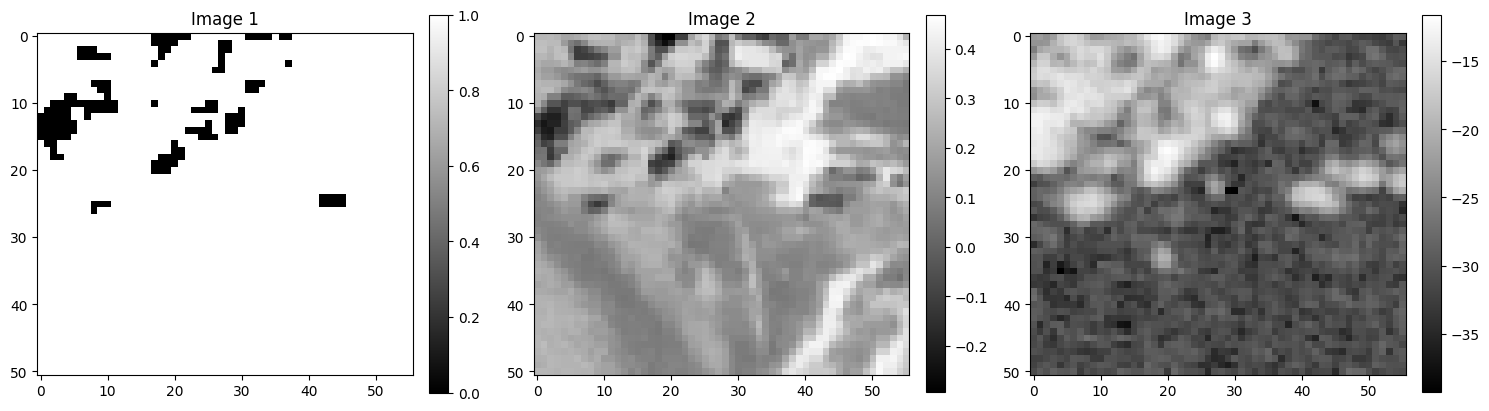

In [ ]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

# File paths for three images
file_paths = [
    '/content/all_DATA/Bangladesh/GEE_Patches/Mask_patch_465.tif',
    '/content/all_DATA/Bangladesh/GEE_Patches/S2_NDWI_patch_465.tif',
    '/content/all_DATA/Bangladesh/GEE_Patches/S1_VH_patch_465.tif'  # replace with your third image path
]

# Load images
images = [tiff.imread(fp) for fp in file_paths]

# Check that all images are 2D or handle differently if needed
for i, img in enumerate(images):
    print(f"Image {i+1} - Type: {type(img)}, Shape: {img.shape}, Dtype: {img.dtype}")

# Create a subplot with 3 axes side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (img, ax) in enumerate(zip(images, axs)):
    if img.ndim == 2:
        im = ax.imshow(img, cmap='gray')
        ax.set_title(f"Image {i+1}")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    else:
        ax.text(0.5, 0.5, "Not a 2D image", ha='center', va='center')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
## Image patch extraction
PATCH_SIZE = 50
def extract_patches(image, patch_size=PATCH_SIZE):
    patches = []
    h, w = image.shape
    for i in range(h // patch_size):
        for j in range(w // patch_size):
            patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patches.append(patch)
    return np.expand_dims(np.array(patches), axis=-1)

def load_and_extract_patches(directory):
    vh_files = sorted([f for f in os.listdir(directory) if f.startswith('S1_VH')])
    ndwi_files = sorted([f for f in os.listdir(directory) if f.startswith('S2_NDWI')])
    mask_files = sorted([f for f in os.listdir(directory) if f.startswith('Mask')])
    print("Number of VH files:", len(vh_files))
    print("Number of NDWI files:", len(ndwi_files))
    print("Number of Mask files:", len(mask_files))
    print("First 3 VH files:")
    for file in vh_files[:3]:
        print(file)

    print("First 3 NDWI files:")
    for file in ndwi_files[:3]:
        print(file)

    print("First 3 Mask files:")
    for file in mask_files[:3]:
        print(file)

    X_vh, X_ndwi, y = [], [], []
    for vh_file, ndwi_file, mask_file in zip(vh_files, ndwi_files, mask_files):
        with rasterio.open(os.path.join(directory, vh_file)) as src: vh_img = np.nan_to_num(src.read(1))
        with rasterio.open(os.path.join(directory, ndwi_file)) as src: ndwi_img = np.nan_to_num(src.read(1))
        with rasterio.open(os.path.join(directory, mask_file)) as src:
            mask_img = (np.nan_to_num(src.read(1)) > 0).astype(np.float32)

        X_vh.append(extract_patches(vh_img))
        X_ndwi.append(extract_patches(ndwi_img))
        y.append(extract_patches(mask_img))

    X_vh = np.concatenate(X_vh)
    X_ndwi = np.concatenate(X_ndwi)
    y = np.concatenate(y)
    print(f"Class balance: {np.mean(y)*100:.2f}% positive pixels")


    return X_vh, X_ndwi, y


### Each returned array (`X_vh`, `X_ndwi`, `y`) has the shape: (num_patches, patch_height, patch_width, num_channels)

X_vh shape: (50, 50, 50, 1)

50 patches in total (from all input images).

Each patch is 50x50 pixels.

1 channel (since radar and NDWI images are single-band)

In [5]:

def display_patch_table(patch, title, i=0):
    data = patch[i, :5, :5, 0]  # first patch, top-left 5x5
    df = pd.DataFrame(data)
    print(f"\n{title} (shape: {patch[i].shape})")
    display(df.style.format("{:.2f}").set_caption(title))


def show_patch_triplets(X_vh, X_ndwi, y, num_patches=3):
    for i in range(num_patches):
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].imshow(X_vh[i, :, :, 0], cmap='gray')
        axs[0].set_title("VH Patch")
        axs[0].axis('off')

        axs[1].imshow(X_ndwi[i, :, :, 0], cmap='gray')
        axs[1].set_title("NDWI Patch")
        axs[1].axis('off')

        axs[2].imshow(y[i, :, :, 0], cmap='gray')
        axs[2].set_title("Mask Patch")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

        display_patch_table(X_vh, "VH Patch", i)
        display_patch_table(X_ndwi, "NDWI Patch", i)
        display_patch_table(y, "Mask Patch", i)



In [6]:
## Data augmentation

def augment_dataset(X_vh, X_ndwi, y):
    def flip_h(x): return np.flip(x, axis=2)
    def flip_v(x): return np.flip(x, axis=1)
    def rot90(x): return np.rot90(x, k=1, axes=(1,2))
    def noise(x): return x + np.random.normal(0, 0.01, x.shape)

    augmented = [(X_vh, X_ndwi, y)]
    for fn in [flip_h, flip_v, rot90, noise]:
        augmented.append((fn(X_vh), fn(X_ndwi), fn(y)))
    X_vh_aug, X_ndwi_aug, y_aug = zip(*augmented)
    return np.concatenate(X_vh_aug), np.concatenate(X_ndwi_aug), np.concatenate(y_aug)

In [7]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading and augmenting patches...
Number of VH files: 50
Number of NDWI files: 50
Number of Mask files: 50
First 3 VH files:
S1_VH_patch_120.tif
S1_VH_patch_136.tif
S1_VH_patch_137.tif
First 3 NDWI files:
S2_NDWI_patch_120.tif
S2_NDWI_patch_136.tif
S2_NDWI_patch_137.tif
First 3 Mask files:
Mask_patch_120.tif
Mask_patch_136.tif
Mask_patch_137.tif
Class balance: 92.93% positive pixels
X_vh shape: (50, 50, 50, 1)
X_ndwi shape: (50, 50, 50, 1)
y shape: (50, 50, 50, 1)
X_vh shape: (250, 50, 50, 1)
X_ndwi shape: (250, 50, 50, 1)
y shape: (250, 50, 50, 1)


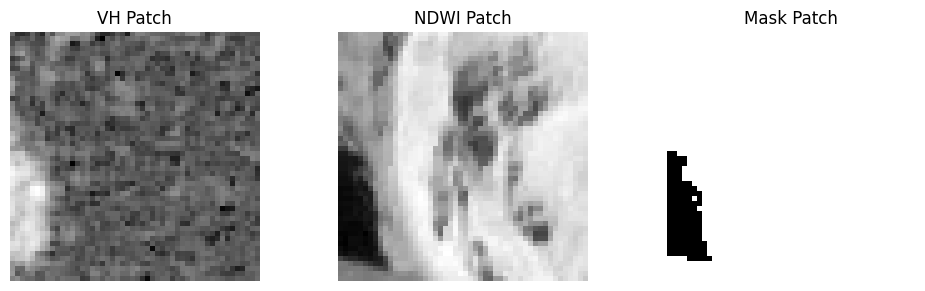


VH Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.33,0.23,0.23,0.25,0.33
1,0.28,0.27,0.30,0.29,0.33
2,0.29,0.35,0.34,0.32,0.29
3,0.33,0.37,0.38,0.36,0.31
4,0.35,0.41,0.44,0.36,0.33



NDWI Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.72,0.73,0.75,0.77,0.79
1,0.72,0.72,0.75,0.76,0.78
2,0.75,0.73,0.76,0.75,0.77
3,0.75,0.74,0.75,0.74,0.75
4,0.75,0.74,0.74,0.73,0.75



Mask Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,1.00,1.00,1.00,1.00,1.00
1,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,1.00,1.00,1.00
3,1.00,1.00,1.00,1.00,1.00
4,1.00,1.00,1.00,1.00,1.00


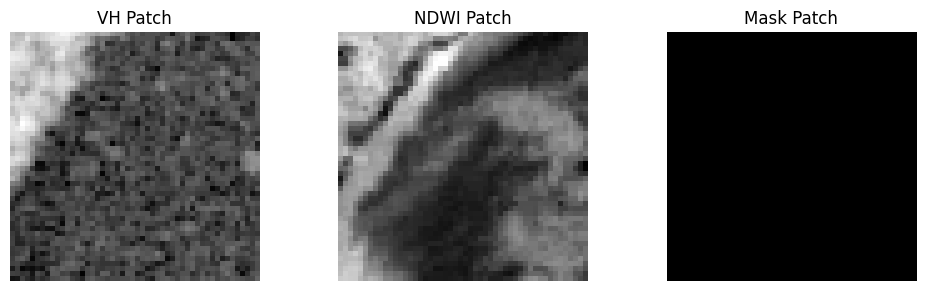


VH Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.55,0.53,0.53,0.57,0.56
1,0.55,0.54,0.55,0.60,0.55
2,0.53,0.56,0.58,0.56,0.51
3,0.55,0.57,0.58,0.55,0.53
4,0.61,0.60,0.60,0.57,0.56



NDWI Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.77,0.79,0.78,0.79,0.79
1,0.79,0.79,0.81,0.82,0.79
2,0.75,0.74,0.76,0.80,0.81
3,0.64,0.65,0.67,0.71,0.78
4,0.58,0.67,0.69,0.72,0.80



Mask Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,1.00,1.00,1.00,1.00,1.00
1,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,1.00,1.00,1.00
3,1.00,1.00,1.00,1.00,1.00
4,1.00,1.00,1.00,1.00,1.00


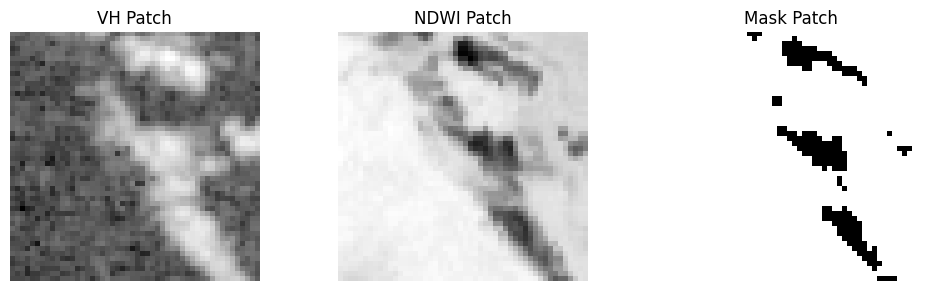


VH Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.30,0.29,0.27,0.25,0.30
1,0.26,0.23,0.24,0.26,0.30
2,0.21,0.26,0.29,0.30,0.27
3,0.17,0.20,0.28,0.28,0.28
4,0.20,0.24,0.28,0.28,0.27



NDWI Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,0.79,0.78,0.76,0.76,0.76
1,0.84,0.84,0.82,0.80,0.80
2,0.85,0.85,0.85,0.84,0.84
3,0.86,0.86,0.86,0.85,0.85
4,0.86,0.87,0.85,0.83,0.83



Mask Patch (shape: (50, 50, 1))


,0,1,2,3,4
0,1.00,1.00,1.00,1.00,1.00
1,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,1.00,1.00,1.00
3,1.00,1.00,1.00,1.00,1.00
4,1.00,1.00,1.00,1.00,1.00


X shape: (250, 50, 50, 2)


In [43]:
## Load and visualize data
country="Bangladesh"
data_dir = f"/content/all_DATA/{country}/GEE_Patches"
print("Loading and augmenting patches...")
X_vh, X_ndwi, y = load_and_extract_patches(data_dir)
# Print dimensions
print(f"X_vh shape: {X_vh.shape}")
print(f"X_ndwi shape: {X_ndwi.shape}")
print(f"y shape: {y.shape}")
# show_patch_triplets(X_vh, X_ndwi, y, num_patches=3)
X_vh = (X_vh - X_vh.min()) / (X_vh.max() - X_vh.min())
X_ndwi = (X_ndwi - X_ndwi.min()) / (X_ndwi.max() - X_ndwi.min())
X_vh, X_ndwi, y = augment_dataset(X_vh, X_ndwi, y)

# Print dimensions
print(f"X_vh shape: {X_vh.shape}")
print(f"X_ndwi shape: {X_ndwi.shape}")
print(f"y shape: {y.shape}")
show_patch_triplets(X_vh, X_ndwi, y, num_patches=3)
X = np.concatenate([X_vh, X_ndwi], axis=-1)
print(f"X shape: {X.shape}")


In [44]:
import numpy as np

# Hyperparameters
PATCH_SIZE = 50
EPOCHS = 50
DIFFUSION_STEPS = 100
MIN_BETA = 1e-4
MAX_BETA = 0.02
betas = np.linspace(MIN_BETA, MAX_BETA, DIFFUSION_STEPS, dtype=np.float32)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas).astype(np.float32)

def forward_diffusion(images, alpha_bars, steps=DIFFUSION_STEPS):
    N, H, W, C = images.shape
    noise = np.random.randn(N, H, W, C).astype(np.float32)
    noisy_images = []

    for t in range(steps):
        sqrt_alpha_bar = np.sqrt(alpha_bars[t])
        sqrt_one_minus_alpha_bar = np.sqrt(1.0 - alpha_bars[t])
        noisy = sqrt_alpha_bar * images + sqrt_one_minus_alpha_bar * noise
        noisy_images.append(noisy)

    return noisy_images, noise


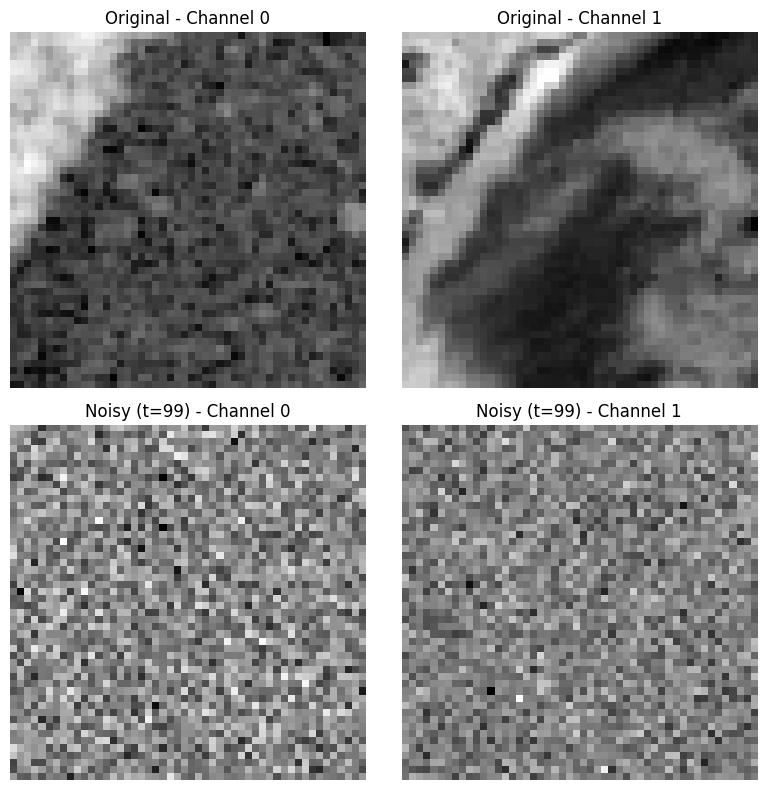

In [45]:
# Apply diffusion
noisy_images, noise = forward_diffusion(X, alpha_bars)

# Plot original and noisy
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ch in range(2):
    axes[0, ch].imshow(X[1, :, :, ch], cmap='gray')
    axes[0, ch].set_title(f"Original - Channel {ch}")
    axes[0, ch].axis('off')

    axes[1, ch].imshow(noisy_images[-1][0, :, :, ch], cmap='gray')
    axes[1, ch].set_title(f"Noisy (t=99) - Channel {ch}")
    axes[1, ch].axis('off')

plt.tight_layout()
plt.show()

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3D Downsampling Block
class DownsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownsamplingBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x

# 3D Upsampling Block
class UpsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsamplingBlock, self).__init__()
        self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, target_shape):
        x = self.relu1(self.bn1(self.upconv(x)))

        # Ensure x matches target spatial shape using interpolation
        x = F.interpolate(x, size=target_shape[2:], mode='trilinear', align_corners=False)

        x = self.relu2(self.bn2(self.conv2(x)))
        return x

# Spectral-Spatial Denoising Network
class SpectralSpatialDenoisingNet(nn.Module):
    def __init__(self, in_channels=2, spectral_bands=32):
        super(SpectralSpatialDenoisingNet, self).__init__()

        self.initial_conv = nn.Conv3d(in_channels, 16, kernel_size=3, padding=1)

        # Encoder
        self.down1 = DownsamplingBlock(16, 32)
        self.down2 = DownsamplingBlock(32, 64)
        self.down3 = DownsamplingBlock(64, 128)

        # Decoder
        self.up1 = UpsamplingBlock(128, 64)
        self.up2 = UpsamplingBlock(64, 32)
        self.up3 = UpsamplingBlock(32, 16)

        # Final Conv
        self.final_conv = nn.Conv3d(16, in_channels, kernel_size=3, padding=1)

    def forward(self, x,return_features=False):
      x1 = self.initial_conv(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      if return_features:
        return [x3,x2,x1]  # or [x2, x3, x4] if you want multi-scale features

      x = self.up1(x4, x3.shape)
      x = x + x3                  # Skip connection
      x = self.up2(x, x2.shape)
      x = x + x2
      x = self.up3(x, x1.shape)
      x = x + x1

      out = self.final_conv(x)
      out = out.permute(0, 1, 4, 2, 3)
      return out ,[x3,x2,x1]


In [47]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

noisy_stack = np.stack(noisy_images[:100], axis=2)
noisy_stack = np.transpose(noisy_stack, (0, 4, 3, 1, 2))
clean_stack = np.transpose(X, (0, 3, 1, 2))
clean_stack = np.expand_dims(clean_stack, axis=2)
clean_stack = np.repeat(clean_stack, 100, axis=2)

print(noisy_stack.shape)
print(clean_stack.shape)

(250, 2, 50, 50, 100)
(250, 2, 100, 50, 50)


In [48]:
class HyperspectralDataset(Dataset):
    def __init__(self, noisy_data, clean_data):
        self.noisy_data = torch.from_numpy(noisy_data).float()
        self.clean_data = torch.from_numpy(clean_data).float()

    def __len__(self):
        return self.noisy_data.shape[0]

    def __getitem__(self, idx):
        return self.noisy_data[idx], self.clean_data[idx]


In [49]:
BATCH_SIZE = 10
dataset = HyperspectralDataset(noisy_stack, clean_stack)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [50]:
model = SpectralSpatialDenoisingNet(in_channels=2, spectral_bands=100)

In [51]:
import torch.nn as nn

for batch_no, (x_batch, y_batch) in enumerate(dataloader):
    output,features = model(x_batch)

    # Example loss (e.g., MSE)
    loss_fn = nn.MSELoss()
    loss = loss_fn(output, y_batch)

    print(f"Batch {batch_no}: output shape = {output.shape}, loss = {loss.item()}")


Batch 0: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.3606562614440918
Batch 1: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.34691178798675537
Batch 2: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.3650847375392914
Batch 3: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.35946428775787354
Batch 4: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.36097896099090576
Batch 5: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.37744078040122986
Batch 6: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.3646683394908905
Batch 7: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.35607123374938965
Batch 8: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.3484843373298645
Batch 9: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.36305350065231323
Batch 10: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.36259448528289795
Batch 11: output shape = torch.Size([10, 2, 100, 50, 50]), loss = 0.

In [52]:
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)

x_batch shape: torch.Size([10, 2, 50, 50, 100])
y_batch shape: torch.Size([10, 2, 100, 50, 50])


In [53]:
print(features[0].shape)
print(features[1].shape)
print(features[2].shape)

torch.Size([10, 64, 13, 13, 25])
torch.Size([10, 32, 25, 25, 50])
torch.Size([10, 16, 50, 50, 100])


Input shape  : torch.Size([10, 2, 50, 50, 100])
Target shape : torch.Size([10, 2, 100, 50, 50])
Output shape : torch.Size([10, 2, 100, 50, 50])


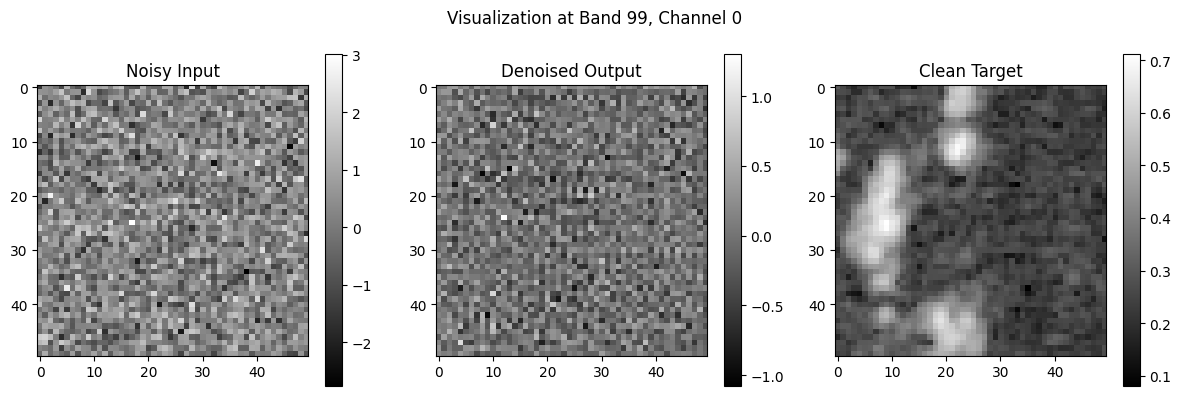

In [54]:
import matplotlib.pyplot as plt

# Just take one batch for visualization
for x_batch, y_batch in dataloader:
    output,features = model(x_batch)
    break

print(f"Input shape  : {x_batch.shape}")
print(f"Target shape : {y_batch.shape}")
print(f"Output shape : {output.shape}")

# Pick one sample
x_sample = x_batch[0].cpu().numpy()
y_sample = y_batch[0].cpu().numpy()
out_sample = output[0].detach().cpu().numpy()

band_idx = 99  # Should be between 0 and 99
channel_idx = 0  # 0 or 1

# Extract spatial 2D slices
input_slice = x_sample[channel_idx, :, :, band_idx]           # shape: [50, 50]
target_slice = y_sample[channel_idx, band_idx, :, :]          # shape: [50, 50]
output_slice = out_sample[channel_idx, band_idx, :, :]        # shape: [50, 50]

# Plot all three
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_slice, cmap='gray')
plt.title("Noisy Input")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(output_slice, cmap='gray')
plt.title("Denoised Output")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(target_slice, cmap='gray')
plt.title("Clean Target")
plt.colorbar()

plt.suptitle(f"Visualization at Band {band_idx}, Channel {channel_idx}")
plt.tight_layout()
plt.show()


In [20]:
import torch.nn.functional as F

def get_diffusion_feature_tensor(features):
    # Target spatial size from last feature
    target_size = features[-1].shape[2:]  # e.g. (H,W) or (D,H,W)
    upsampled_feats = []
    for f in features:
        f_up = F.interpolate(f, size=target_size, mode="trilinear", align_corners=False)
        upsampled_feats.append(f_up)
    # Now concatenate along channel dim
    F_cat = torch.cat(upsampled_feats, dim=1)
    return F_cat


def extract_patch_tensor(features, kernel_size=3):

    B, C, H, W = features.shape
    patches = F.unfold(features, kernel_size=kernel_size, padding=kernel_size // 2)  # [B, C*k*k, H*W]
    patches = patches.permute(0, 2, 1)  # [B, H*W, C*k*k]
    patches = patches.view(B, H * W, C, kernel_size, kernel_size)  # [B, H*W, C, k, k]
    return patches


In [21]:
print("clean_stack.shape:", y.shape)
masked_ratio = np.mean(y, axis=(1, 2, 3))
print("masked_ratio.shape:", masked_ratio.shape)
threshold = np.median(masked_ratio)
#print(threshold)
labels_binary = (masked_ratio > threshold).astype(int)
print("labels_binary.shape:", labels_binary.shape)


clean_stack.shape: (90, 50, 50, 1)
masked_ratio.shape: (90,)
labels_binary.shape: (90,)


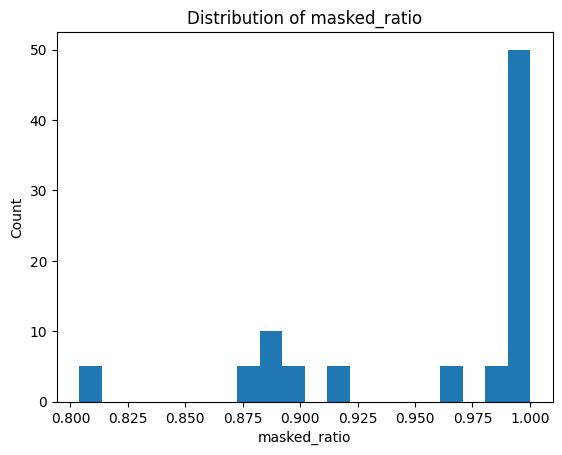

min: 0.8038997227801349 max: 1.0002292641302708


In [25]:
import matplotlib.pyplot as plt

plt.hist(masked_ratio, bins=20)
plt.title("Distribution of masked_ratio")
plt.xlabel("masked_ratio")
plt.ylabel("Count")
plt.show()

print("min:", masked_ratio.min(), "max:", masked_ratio.max())


In [22]:
class ClassifierDataset(Dataset):
    def __init__(self, noisy_data, labels_binary):
        self.noisy_data = torch.from_numpy(noisy_data).float()  # Shape: [N, 2, 100, 50, 50]
        self.labels = torch.from_numpy(labels_binary).long()    # Shape: [N]

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        return self.noisy_data[idx], self.labels[idx]

classifier_dataset = ClassifierDataset(noisy_stack, labels_binary)


In [23]:
from torch.utils.data import random_split

total_size = len(classifier_dataset)
train_size = int(0.7 * total_size)
test_size = total_size - train_size   # Ensure all data is used

# Fixed seed via generator
train_dataset,test_dataset = random_split(
    classifier_dataset,
    [train_size,test_size],
    generator=torch.Generator().manual_seed(42)
)

In [24]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [25]:
print(labels_binary.shape)
print(noisy_stack.shape)

(90,)
(90, 2, 50, 50, 100)


In [26]:
class PatchTokenizer(nn.Module):
    def __init__(self, in_channels, embed_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)  # keeps shape
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.project = nn.Linear(in_channels * 3 * 3, embed_dim)


    def forward(self, patch_tensor):
        # patch_tensor: [B, N, C, k, k]
        B, N, C, k, _ = patch_tensor.shape
        patch_tensor = patch_tensor.reshape(B * N, C, k, k)
        x = self.relu(self.bn(self.conv(patch_tensor)))  # [B*N, C, k, k]
        x = x.view(B * N, -1)  # Flatten
        tokens = self.project(x)  # [B*N, embed_dim]
        return tokens.view(B, N, -1)  # [B, N, embed_dim]


In [27]:
import torch
import torch.nn as nn
import math

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, embed_dim)  # (max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices

        pe = pe.unsqueeze(0)  # (1, max_len, embed_dim)

        # Register as buffer so it is saved but not a parameter
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


In [28]:
class TransformerClassifier(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=4, num_classes=2, max_tokens=5000):
        super().__init__()
        self.pos_encoder = SinusoidalPositionalEncoding(embed_dim, max_len=max_tokens)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, tokens):
        # tokens: [B, N, embed_dim]
        tokens = self.pos_encoder(tokens)
        x = self.transformer(tokens)  # [B, N, embed_dim]
        x = x.mean(dim=1)             # global average pooling over tokens
        return self.mlp_head(x)       # [B, num_classes]


In [29]:
class AttentionBasedClassifier(nn.Module):
    def __init__(self, in_channels, embed_dim=128, num_classes=16):
        super().__init__()
        self.tokenizer = PatchTokenizer(in_channels, embed_dim)
        self.encoder = TransformerClassifier(embed_dim, num_classes=num_classes)

    def forward(self, features):
        # features: [B, C, H, W]
        patches = extract_patch_tensor(features)  # [B, N, C, k, k]
        tokens = self.tokenizer(patches)         # [B, N, embed_dim]
        out = self.encoder(tokens)               # [B, num_classes]
        return out


In [30]:
combined_features = get_diffusion_feature_tensor(features)
print(combined_features.shape)  # [B, C_total, H, W]
in_channels = combined_features.shape[1]


torch.Size([10, 112, 50, 50, 100])


In [31]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
noisy_images, noise = forward_diffusion(X, alpha_bars)  # both are list of [N, H, W, C]
#initialized model before
#model = SpectralSpatialDenoisingNet(in_channels=2).to(device)
criterion = nn.CrossEntropyLoss()

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [33]:
print(in_channels)

112


In [34]:
embed_dim = 128                          # Choose embedding size (start with 128)
num_classes = 2
classifier = AttentionBasedClassifier(in_channels=in_channels, embed_dim=128, num_classes=2)
classifier = classifier.to(device)

In [35]:
# Assuming:
# model: SpectralSpatialDenoisingNet instance
# classifier: AttentionBasedClassifier instance
#classifier_dataset = ClassifierDataset(noisy_stack, labels_binary)
#train_dataloader = DataLoader(classifier_dataset, batch_size=16, shuffle=True)

# criterion: classification loss, e.g. nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
# optimizer: optimizer for classifier parameters (and denoiser if training jointly)
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
# device: cuda or cpu
model=model.to(device)


for epoch in range(EPOCHS):
    model.eval()  # Freeze denoiser
    classifier.train()

    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)  # e.g. shape: [B, C, H, W]
        labels = labels.long()


        with torch.no_grad():
            features = model(inputs, return_features=True)  # list of tensors


        combined_features = get_diffusion_feature_tensor(features)  # [B, C_total, H, W]
        # From shape [B, C, H, W, D]
        features_4d = combined_features.mean(dim=-1)  # or dim=1 if you want to collapse channels

        outputs = classifier(features_4d)


        #outputs = classifier(combined_features)  # [B, num_classes]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Tracking ---
        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)

        running_corrects += torch.sum(preds == labels).item()
        total_samples += inputs.size(0)


    epoch_loss = running_loss / total_samples
    epoch_acc = float(running_corrects) / total_samples

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")


Epoch 1/50 - Loss: 0.9079, Acc: 0.4516
Epoch 2/50 - Loss: 0.7567, Acc: 0.4839
Epoch 3/50 - Loss: 0.7063, Acc: 0.4839
Epoch 4/50 - Loss: 0.7189, Acc: 0.5161
Epoch 5/50 - Loss: 0.6965, Acc: 0.5161
Epoch 6/50 - Loss: 0.6947, Acc: 0.5161
Epoch 7/50 - Loss: 0.7018, Acc: 0.4839
Epoch 8/50 - Loss: 0.6926, Acc: 0.5323
Epoch 9/50 - Loss: 0.7030, Acc: 0.5161
Epoch 10/50 - Loss: 0.6930, Acc: 0.5161
Epoch 11/50 - Loss: 0.6929, Acc: 0.4355
Epoch 12/50 - Loss: 0.6932, Acc: 0.4839
Epoch 13/50 - Loss: 0.6892, Acc: 0.5806
Epoch 14/50 - Loss: 0.6952, Acc: 0.5161
Epoch 15/50 - Loss: 0.6899, Acc: 0.5161
Epoch 16/50 - Loss: 0.6861, Acc: 0.5806
Epoch 17/50 - Loss: 0.6954, Acc: 0.5323
Epoch 18/50 - Loss: 0.6992, Acc: 0.4516
Epoch 19/50 - Loss: 0.6984, Acc: 0.4355
Epoch 20/50 - Loss: 0.6946, Acc: 0.5161
Epoch 21/50 - Loss: 0.6809, Acc: 0.6129
Epoch 22/50 - Loss: 0.6946, Acc: 0.4032
Epoch 23/50 - Loss: 0.6778, Acc: 0.4677
Epoch 24/50 - Loss: 0.6767, Acc: 0.6613
Epoch 25/50 - Loss: 0.6816, Acc: 0.5806
Epoch 26/

In [36]:
print("Class counts:", np.bincount(labels_binary))


Class counts: [45 45]


In [37]:
print(labels.dtype, labels.unique())  # should be torch.int64 and [0, 1]


torch.int64 tensor([0, 1], device='cuda:0')


In [38]:
for inputs, labels in train_loader:
    print("Labels in batch:", labels)
    print("Unique labels:", torch.unique(labels))
    break


Labels in batch: tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1])
Unique labels: tensor([0, 1])


In [39]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, jaccard_score, cohen_kappa_score
)
import torch

def compute_metrics(phase, true_labels, predicted_labels):
    flat_true = np.ravel(true_labels)
    flat_pred = np.ravel(predicted_labels)

    return {
        "Timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "Phase": phase,
        "Accuracy": accuracy_score(flat_true, flat_pred),
        "Balanced Accuracy": balanced_accuracy_score(flat_true, flat_pred),
        "Precision": precision_score(flat_true, flat_pred, average='macro', zero_division=0),
        "Recall": recall_score(flat_true, flat_pred, average='macro', zero_division=0),
        "F1 Score": f1_score(flat_true, flat_pred, average='macro', zero_division=0),
        "IoU": jaccard_score(flat_true, flat_pred, average='macro', zero_division=0),
        "Cohen Kappa": cohen_kappa_score(flat_true, flat_pred),
        "Positive %": round(np.mean(flat_true) * 100, 2),
    }

def evaluate_and_log(model,classifier, dataloader, device, phase):
    model.eval()
    classifier.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            _,features=model(inputs,return_features=False)
            combined_features = get_diffusion_feature_tensor(features)  # [B, C_total, H, W]
            # From shape [B, C, H, W, D]
            features_4d = combined_features.mean(dim=-1)

            outputs = classifier(features_4d)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = compute_metrics(phase, all_labels, all_preds)
    return metrics


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_metrics = evaluate_and_log(model,classifier, train_loader, device, "train")
test_metrics = evaluate_and_log(model,classifier, test_loader, device, "test")

# Combine into DataFrame
metrics_df = pd.DataFrame([train_metrics, test_metrics])

# Save to CSV
metrics_df.to_csv(f"spectraldiff_{country}.csv", index=False)
print("Saved metrics")


✅ Saved metrics to metrics.csv
